# Lab 4
Prepared:
 - **Szymon Budziak**
 - **Krzysztof Gwiazda**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics

from scipy.stats import shapiro
from skspatial.objects import Line, Point

## 1. Prepare own dataset

In [2]:
X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=10,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

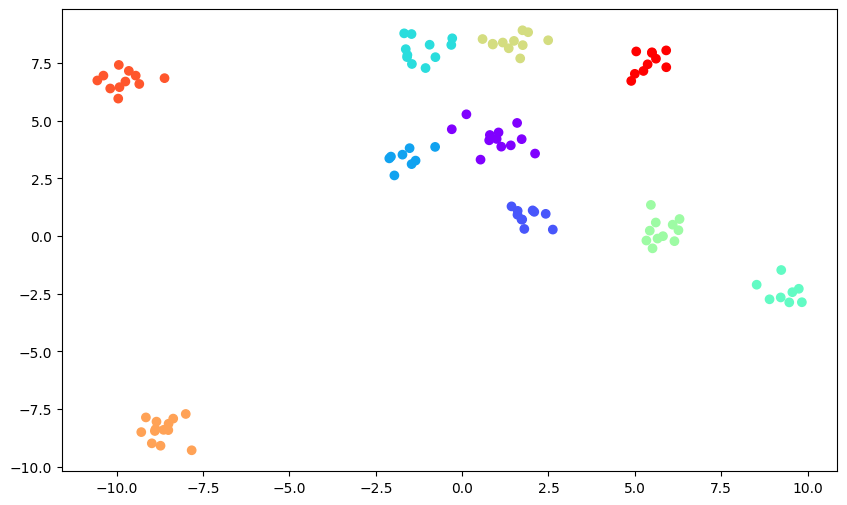

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rainbow')

## 2. Selecting clustering performance evaluation

Selected clustering performance evaluation:
- Rand index
- Mutual Information based scores

## 3. Elbow rule

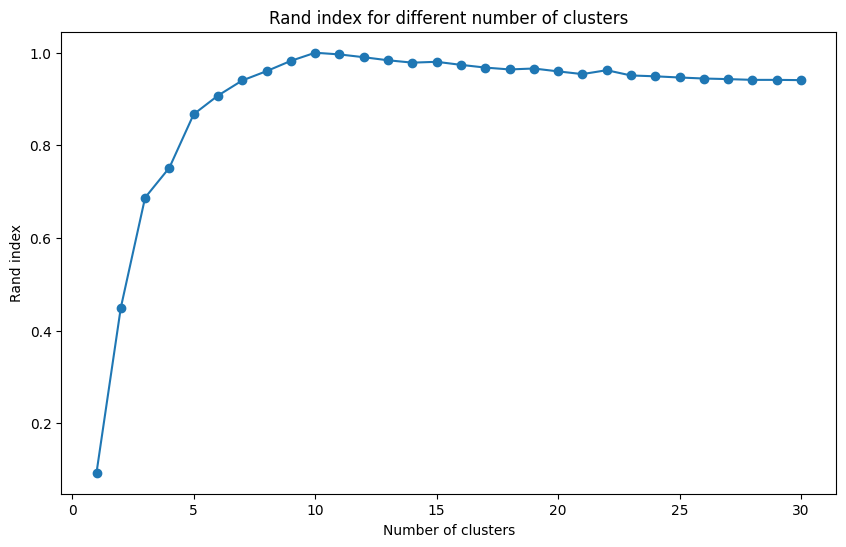

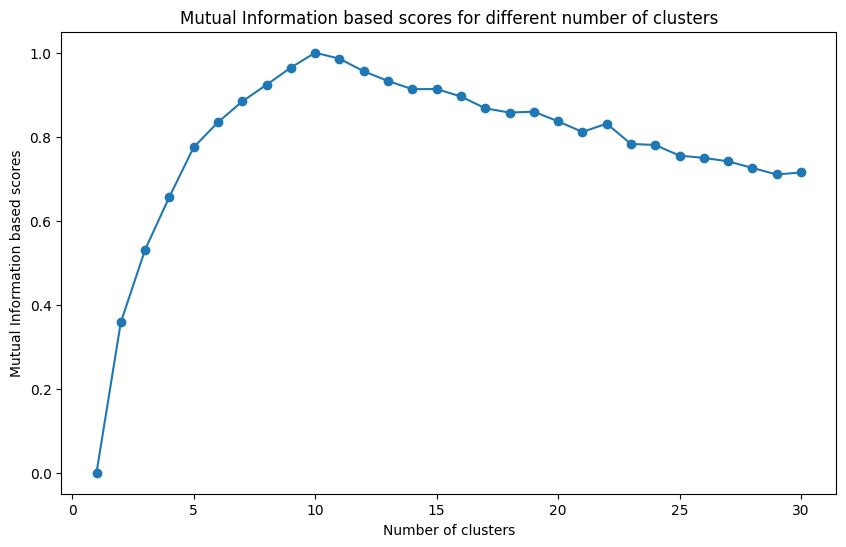

In [5]:
rand_index_scores = []
adjusted_mutual_info_scores = []

for i in range(1, 31):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_train)

    rand_index = metrics.rand_score(y_train, kmeans.labels_)
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(y_train, kmeans.labels_)
    rand_index_scores.append(rand_index)
    adjusted_mutual_info_scores.append(adjusted_mutual_info)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), rand_index_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Rand index')
plt.title('Rand index for different number of clusters')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), adjusted_mutual_info_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Mutual Information based scores')
plt.title('Mutual Information based scores for different number of clusters')
plt.show()

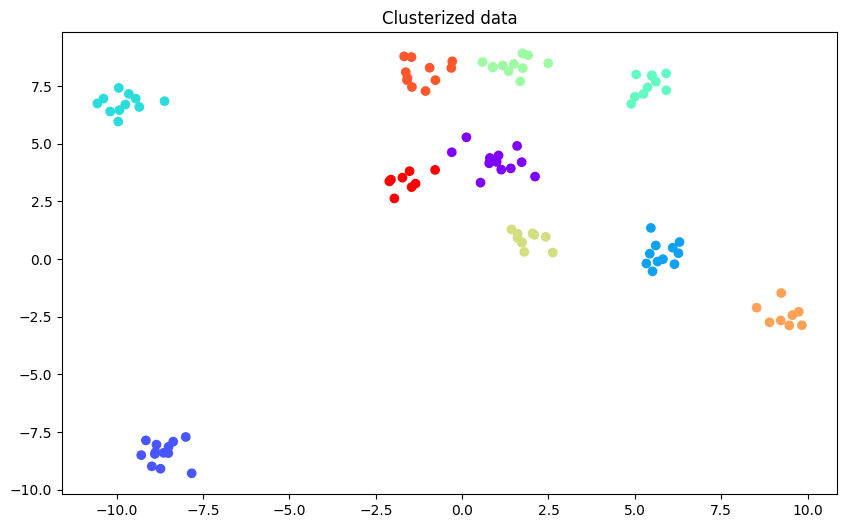

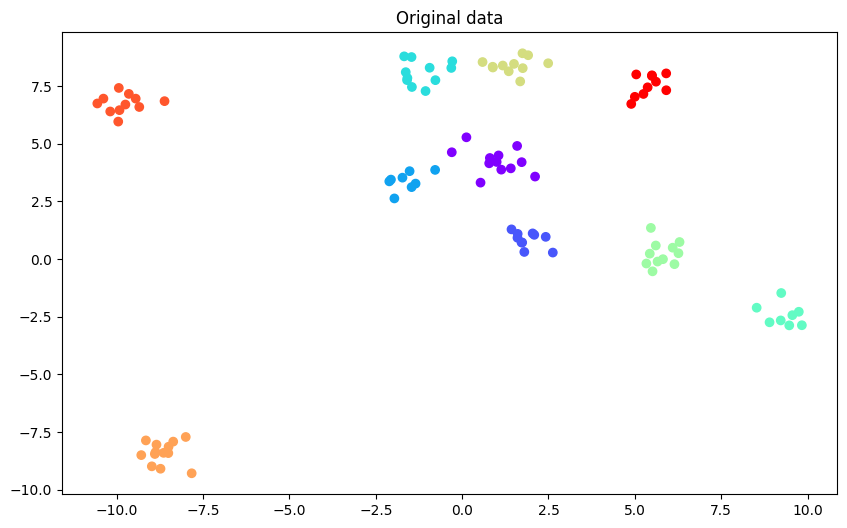

In [6]:
kmeans = KMeans(n_clusters=10,
                init='k-means++',
                max_iter=300,
                n_init=10,
                random_state=0)
kmeans.fit(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title('Clusterized data')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rainbow')
plt.title('Original data')
plt.show()

In the above case, it is clear that the optimal number of clusters is 10. This value is as expected, since there are 10 sets of points in the set. Both metrics indicated the same optimal number of clusters. In addition, clustering with 10 clusters is an ideal representation of dividing data into 10 sets - so it makes sense.

## 4. Adaptive hierarchical selection of the number of clusters

In [7]:
def adaptive_hierarchical_kmeans(X, gaussianTreshold=0.1, clusterSizeTreshold=7):
    if len(X) < clusterSizeTreshold:
        return 1

    kmeans = KMeans(n_clusters=2,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X)

    centroids = kmeans.cluster_centers_

    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title('Clusterized data')
    plt.show()

    c1x = centroids[0][0]
    c1y = centroids[0][1]
    c2x = centroids[1][0]
    c2y = centroids[1][1]

    data = []
    for i in range(len(X)):
        line = Line(point=[c1x, c1y], direction=[c2x - c1x, c2y - c1y])
        projected_point = line.project_point(X[i])

        distance = math.sqrt((projected_point[0] - X[i][0]) ** 2 + (projected_point[1] - X[i][1]) ** 2)

        data.append((projected_point[0], distance))

    distances = [x[1] for x in data]

    _, p = shapiro(distances)
    if p > gaussianTreshold:
        print("--------------------ONE CLUSTER--------------------")
        return 1
    else:
        print("--------------------SPLITTING INTO CLUSTERS--------------------")
        subclusters = kmeans.labels_
        subclusters_data = [[], []]
        for i in range(len(X)):
            subclusters_data[subclusters[i]].append(X[i])

        return adaptive_hierarchical_kmeans(np.array(subclusters_data[0])) + \
            adaptive_hierarchical_kmeans(np.array(subclusters_data[1]))

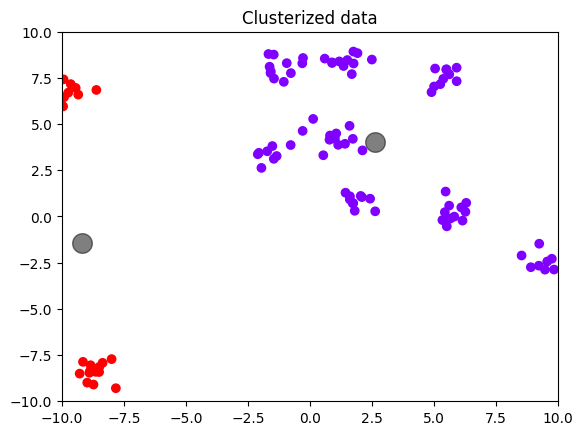

--------------------SPLITTING INTO CLUSTERS--------------------


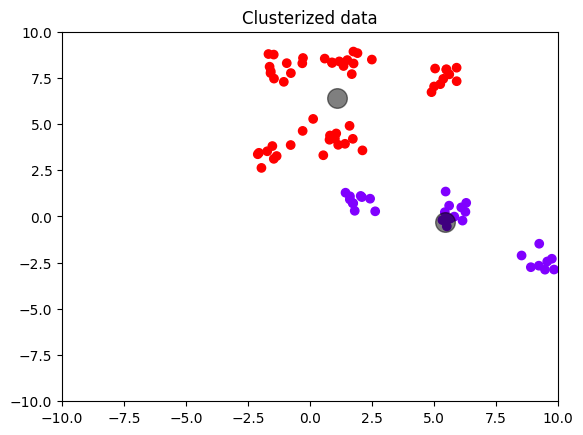

--------------------SPLITTING INTO CLUSTERS--------------------


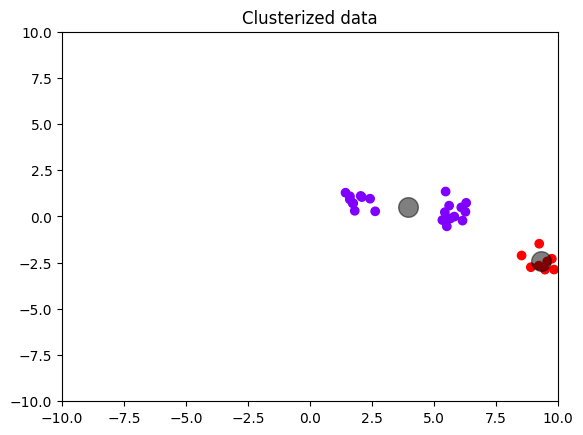

--------------------SPLITTING INTO CLUSTERS--------------------


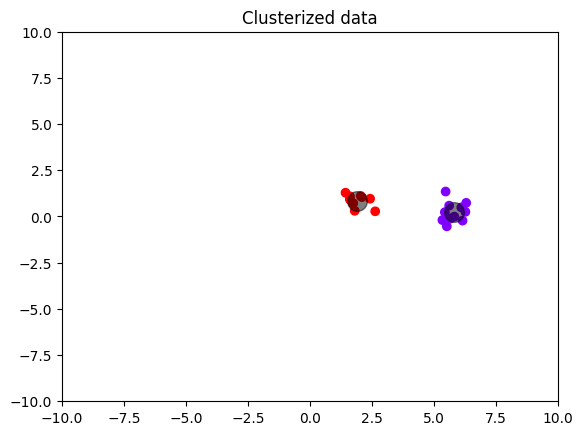

--------------------SPLITTING INTO CLUSTERS--------------------


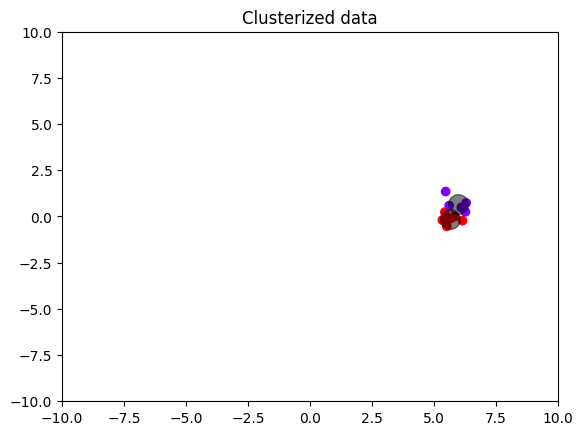

--------------------ONE CLUSTER--------------------


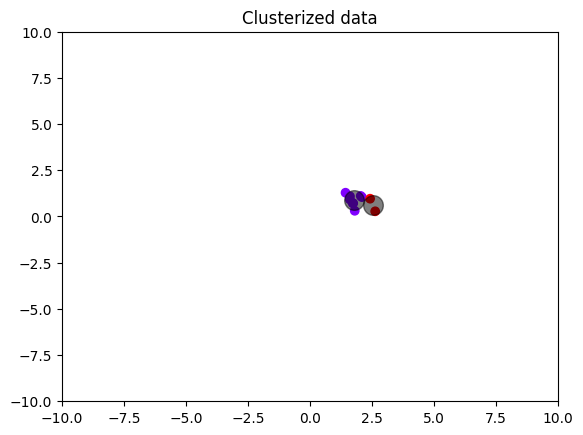

--------------------ONE CLUSTER--------------------


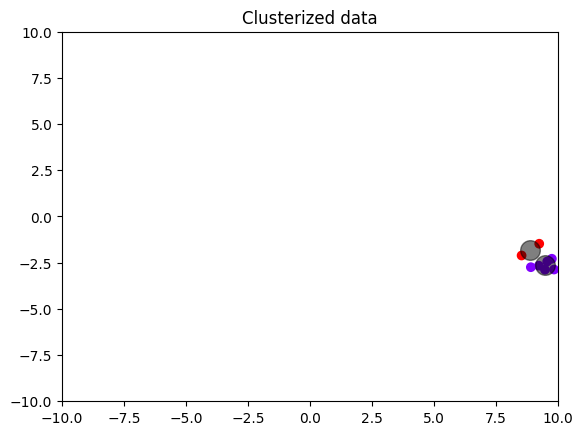

--------------------SPLITTING INTO CLUSTERS--------------------


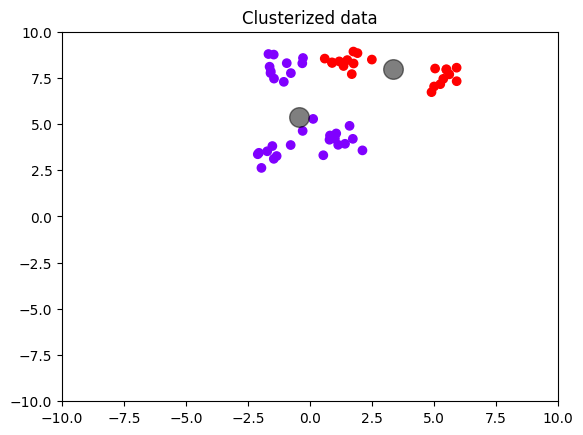

--------------------ONE CLUSTER--------------------


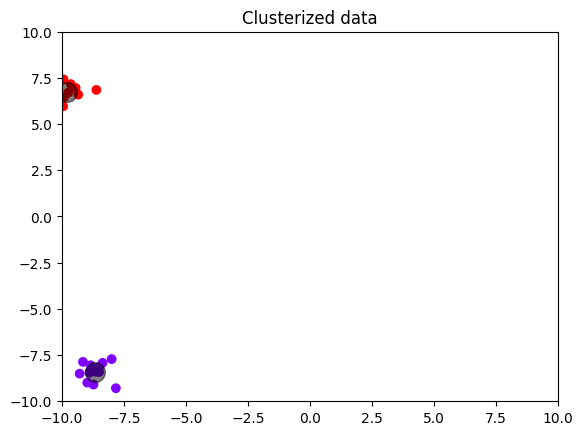

--------------------SPLITTING INTO CLUSTERS--------------------


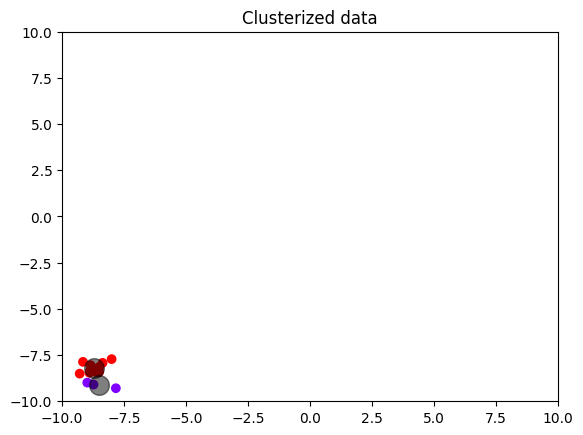

--------------------ONE CLUSTER--------------------


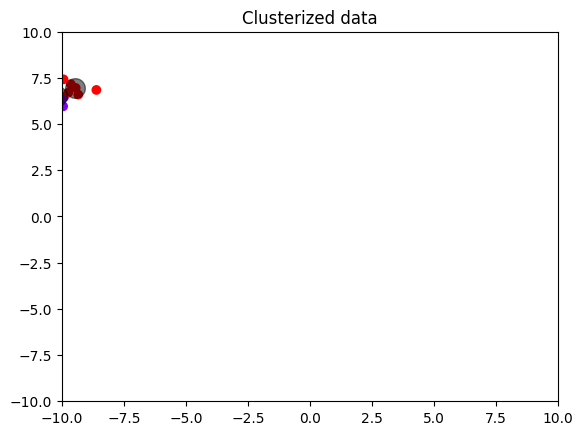

--------------------ONE CLUSTER--------------------
Number of clusters: 7


In [8]:
print(f'Number of clusters: {adaptive_hierarchical_kmeans(X_train)}')

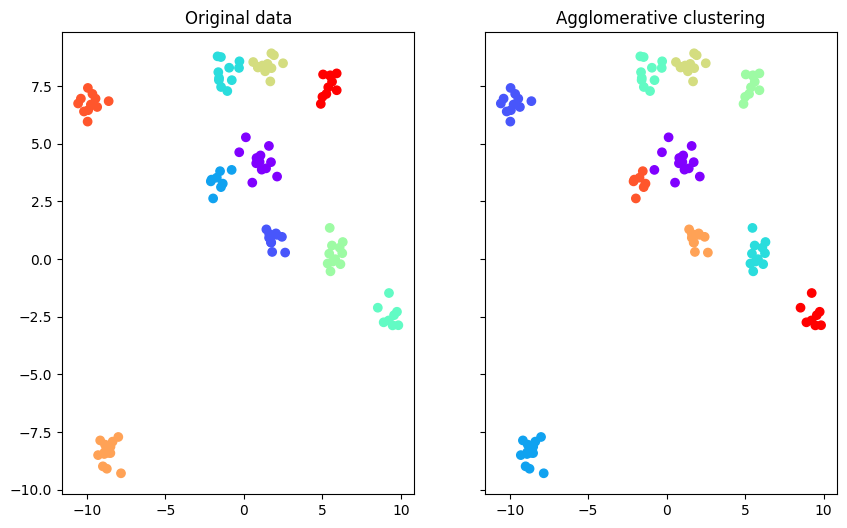

In [9]:
ac = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='complete')
y_ac = ac.fit_predict(X_train)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rainbow')
ax1.set_title('Original data')
ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_ac, cmap='rainbow')
ax2.set_title('Agglomerative clustering')
plt.show()

The hierarchical clustering algorithm used above is far from ideal. A perfect example of its weakness is one of the plots, where it separated two clusters out of 5 real ones. Unfortunately, it chose the midpoints of the clusters in such a way that they are +- equidistant from the cluster points. In this case, the algorithm concludes that the distribution is "gaussian" and does not try to divide it. In this case, the k-means algorithm performs better because it does not assume any data distribution.

---
The AgglomerativeClustering algorithm tested above with the `linkage="complete"` parameter performs as well as K-means.

## 5. A collision with reality

In [10]:
df = pd.read_csv('lab_4_players.csv', header=0)
pd.set_option('display.max_columns', None)

df.head()

positions = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
             'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
for column in positions:
    df[column] = df[column].apply(lambda x: eval(x)).astype('int64')

/tmp/ipykernel_18594/3893128829.py:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('lab_4_players.csv', header=0)


In [11]:
# data cleanup
sofifa_id_name_mapping = {}
for index, row in df.iterrows():
    sofifa_id_name_mapping[row['sofifa_id']] = row['short_name']

In [12]:
# select only numerical columns
df = df.select_dtypes(include=['float64', 'int64'])

# drop unnecessary columns
df = df.drop([
    'club_team_id',
    'club_jersey_number',
    'club_contract_valid_until',
    'nationality_id',
    'nation_team_id',
    'nation_jersey_number',
    'international_reputation',
    'release_clause_eur',
], axis=1)

# convert NaN values to 0
df = df.fillna(0)

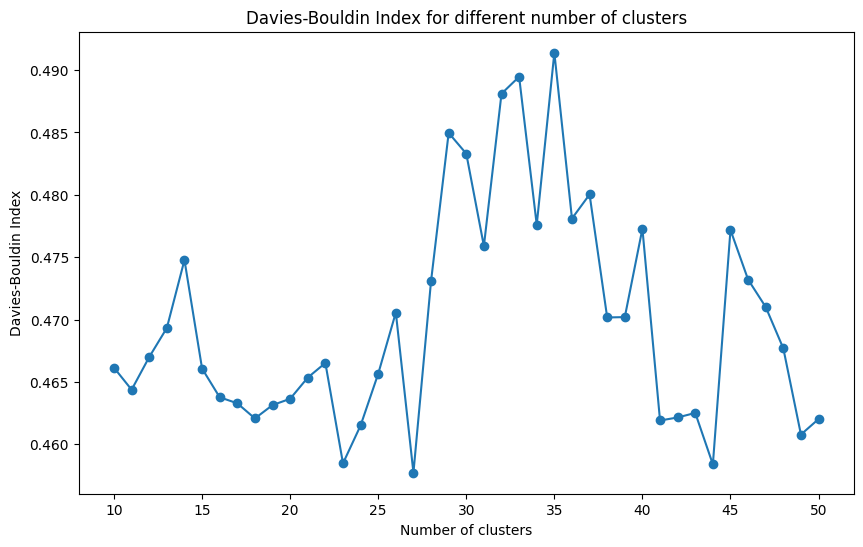

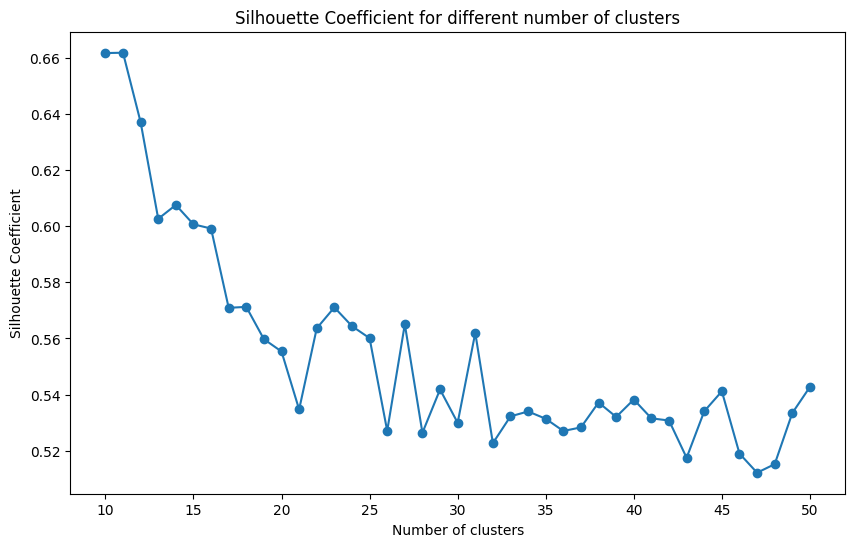

In [13]:
davies_bouldin_scores = []
silhouette_scores = []
for i in range(10, 51):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(df)

    davies_bouldin = metrics.davies_bouldin_score(df, kmeans.labels_)
    silhouette = metrics.silhouette_score(df, kmeans.labels_)
    davies_bouldin_scores.append(davies_bouldin)
    silhouette_scores.append(silhouette)

plt.figure(figsize=(10, 6))
plt.plot(range(10, 51), davies_bouldin_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for different number of clusters')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(10, 51), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for different number of clusters')
plt.show()

A good elbow point for this metric would be a cluster count of 26.

In [14]:
kmeans = KMeans(n_clusters=26,
                init='k-means++',
                max_iter=300,
                n_init=10,
                random_state=0)
kmeans.fit(df)

representatives = []
for i in range(21):
    representatives.append(df.iloc[(kmeans.labels_ == i).nonzero()[0]
    [np.argmin(np.linalg.norm(df[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis=1))]])

for representative in representatives:
    print(sofifa_id_name_mapping[representative['sofifa_id']])

L. Fritzson
J. Larsson
J. Sancho
Merino
A. Zeneli
C. Bassogog
L. Martínez
S. Guirassy
K. Tierney
K. Mbappé
F. Kamberi
P. Højbjerg
S. Widmer
K. Ajer
H. Son
T. Müller
Luiz Felipe
H. Kane
A. Miranchuk
K. Trippier
M. Kvesić


There are 26 different items in our dataset, so 26 clusters is what we expected and we get a good metric result. Probably some of the positions have been merged into one, because they are very similar to each other. In the list of names, we also see only one name of the goalkeeper, which also makes sense.